# Convolutions for Images
:label:`sec_conv_layer`

Now that we understand how convolutional layers work in theory,
we are ready to see how they work in practice.
Building on our motivation of convolutional neural networks
as efficient architectures for exploring structure in image data,
we stick with images as our running example.


In [1]:
import torch
from torch import nn
from d2l import torch as d2l

## The Cross-Correlation Operation

Recall that strictly speaking, convolutional layers
are a  misnomer, since the operations they express
are more accurately described as cross-correlations.
Based on our descriptions of convolutional layers in :numref:`sec_why-conv`,
in such a layer, an input tensor
and a kernel tensor are combined
to produce an output tensor through a (**cross-correlation operation.**)

Let's ignore channels for now and see how this works
with two-dimensional data and hidden representations.
In :numref:`fig_correlation`,
the input is a two-dimensional tensor
with a height of 3 and width of 3.
We mark the shape of the tensor as $3 \times 3$ or ($3$, $3$).
The height and width of the kernel are both 2.
The shape of the *kernel window* (or *convolution window*)
is given by the height and width of the kernel
(here it is $2 \times 2$).

![Two-dimensional cross-correlation operation. The shaded portions are the first output element as well as the input and kernel tensor elements used for the output computation: $0\times0+1\times1+3\times2+4\times3=19$.](../img/correlation.svg)
:label:`fig_correlation`

In the two-dimensional cross-correlation operation,
we begin with the convolution window positioned
at the upper-left corner of the input tensor
and slide it across the input tensor,
both from left to right and top to bottom.
When the convolution window slides to a certain position,
the input subtensor contained in that window
and the kernel tensor are multiplied elementwise
and the resulting tensor is summed up
yielding a single scalar value.
This result gives the value of the output tensor
at the corresponding location.
Here, the output tensor has a height of 2 and width of 2
and the four elements are derived from
the two-dimensional cross-correlation operation:

$$
0\times0+1\times1+3\times2+4\times3=19,\\
1\times0+2\times1+4\times2+5\times3=25,\\
3\times0+4\times1+6\times2+7\times3=37,\\
4\times0+5\times1+7\times2+8\times3=43.
$$

Note that along each axis, the output size
is slightly smaller than the input size.
Because the kernel has width and height greater than $1$,
we can only properly compute the cross-correlation
for locations where the kernel fits wholly within the image,
the output size is given by the input size $n_\textrm{h} \times n_\textrm{w}$
minus the size of the convolution kernel $k_\textrm{h} \times k_\textrm{w}$
via

$$(n_\textrm{h}-k_\textrm{h}+1) \times (n_\textrm{w}-k_\textrm{w}+1).$$

This is the case since we need enough space
to "shift" the convolution kernel across the image.
Later we will see how to keep the size unchanged
by padding the image with zeros around its boundary
so that there is enough space to shift the kernel.
Next, we implement this process in the `corr2d` function,
which accepts an input tensor `X` and a kernel tensor `K`
and returns an output tensor `Y`.


In [2]:
def corr2d(X, K):  #@save
    """Compute 2D cross-correlation."""
    h, w = K.shape
    Y = torch.zeros((X.shape[0] - h + 1, X.shape[1] - w + 1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            Y[i, j] = (X[i:i + h, j:j + w] * K).sum()
    return Y

We can construct the input tensor `X` and the kernel tensor `K`
from :numref:`fig_correlation`
to [**validate the output of the above implementation**]
of the two-dimensional cross-correlation operation.


In [3]:
X = torch.tensor([[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]])
K = torch.tensor([[0.0, 1.0], [2.0, 3.0]])
corr2d(X, K)

tensor([[19., 25.],
        [37., 43.]])

## Convolutional Layers

A convolutional layer cross-correlates the input and kernel
and adds a scalar bias to produce an output.
The two parameters of a convolutional layer
are the kernel and the scalar bias.
When training models based on convolutional layers,
we typically initialize the kernels randomly,
just as we would with a fully connected layer.

We are now ready to [**implement a two-dimensional convolutional layer**]
based on the `corr2d` function defined above.
In the `__init__` constructor method,
we declare `weight` and `bias` as the two model parameters.
The forward propagation method
calls the `corr2d` function and adds the bias.


In [4]:
class Conv2D(nn.Module):
    def __init__(self, kernel_size):
        super().__init__()
        self.weight = nn.Parameter(torch.rand(kernel_size))
        self.bias = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        return corr2d(x, self.weight) + self.bias

In
$h \times w$ convolution
or an $h \times w$ convolution kernel,
the height and width of the convolution kernel are $h$ and $w$, respectively.
We also refer to
a convolutional layer with an $h \times w$
convolution kernel simply as an $h \times w$ convolutional layer.


## Object Edge Detection in Images

Let's take a moment to parse [**a simple application of a convolutional layer:
detecting the edge of an object in an image**]
by finding the location of the pixel change.
First, we construct an "image" of $6\times 8$ pixels.
The middle four columns are black ($0$) and the rest are white ($1$).


In [5]:
X = torch.ones((6, 8))
X[:, 2:6] = 0
X

tensor([[1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.]])

Next, we construct a kernel `K` with a height of 1 and a width of 2.
When we perform the cross-correlation operation with the input,
if the horizontally adjacent elements are the same,
the output is 0. Otherwise, the output is nonzero.
Note that this kernel is a special case of a finite difference operator. At location $(i,j)$ it computes $x_{i,j} - x_{(i+1),j}$, i.e., it computes the difference between the values of horizontally adjacent pixels. This is a discrete approximation of the first derivative in the horizontal direction. After all, for a function $f(i,j)$ its derivative $-\partial_i f(i,j) = \lim_{\epsilon \to 0} \frac{f(i,j) - f(i+\epsilon,j)}{\epsilon}$. Let's see how this works in practice.


In [6]:
K = torch.tensor([[1.0, -1.0]])

We are ready to perform the cross-correlation operation
with arguments `X` (our input) and `K` (our kernel).
As you can see, [**we detect $1$ for the edge from white to black
and $-1$ for the edge from black to white.**]
All other outputs take value $0$.


In [7]:
Y = corr2d(X, K)
Y

tensor([[ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.]])

We can now apply the kernel to the transposed image.
As expected, it vanishes. [**The kernel `K` only detects vertical edges.**]


In [8]:
corr2d(X.t(), K)

tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])

## Learning a Kernel

Designing an edge detector by finite differences `[1, -1]` is neat
if we know this is precisely what we are looking for.
However, as we look at larger kernels,
and consider successive layers of convolutions,
it might be impossible to specify
precisely what each filter should be doing manually.

Now let's see whether we can [**learn the kernel that generated `Y` from `X`**]
by looking at the input--output pairs only.
We first construct a convolutional layer
and initialize its kernel as a random tensor.
Next, in each iteration, we will use the squared error
to compare `Y` with the output of the convolutional layer.
We can then calculate the gradient to update the kernel.
For the sake of simplicity,
in the following
we use the built-in class
for two-dimensional convolutional layers
and ignore the bias.


In [57]:
# Construct a two-dimensional convolutional layer with 1 output channel and a
# kernel of shape (1, 2). For the sake of simplicity, we ignore the bias here
conv2d = nn.LazyConv2d(1, kernel_size=(1, 2), bias=False)

# The two-dimensional convolutional layer uses four-dimensional input and
# output in the format of (example, channel, height, width), where the batch
# size (number of examples in the batch) and the number of channels are both 1
X = X.reshape((1, 1, 6, 8))
Y = Y.reshape((1, 1, 6, 7))
lr = 3e-2  # Learning rate

for i in range(10):
    Y_hat = conv2d(X)
    l = (Y_hat - Y) ** 2
    conv2d.zero_grad()
    l.sum().backward()
    # Update the kernel
    conv2d.weight.data[:] -= lr * conv2d.weight.grad
    if (i + 1) % 2 == 0:
        print(f'epoch {i + 1}, loss {l.sum():.3f}')

epoch 2, loss 4.265
epoch 4, loss 0.874
epoch 6, loss 0.211
epoch 8, loss 0.062
epoch 10, loss 0.021


Note that the error has dropped to a small value after 10 iterations. Now we will [**take a look at the kernel tensor we learned.**]


In [10]:
conv2d.weight.data.reshape((1, 2))

tensor([[ 0.9736, -1.0137]])

Indeed, the learned kernel tensor is remarkably close
to the kernel tensor `K` we defined earlier.

## Cross-Correlation and Convolution

Recall our observation from :numref:`sec_why-conv` of the correspondence
between the cross-correlation and convolution operations.
Here let's continue to consider two-dimensional convolutional layers.
What if such layers
perform strict convolution operations
as defined in :eqref:`eq_2d-conv-discrete`
instead of cross-correlations?
In order to obtain the output of the strict *convolution* operation, we only need to flip the two-dimensional kernel tensor both horizontally and vertically, and then perform the *cross-correlation* operation with the input tensor.

It is noteworthy that since kernels are learned from data in deep learning,
the outputs of convolutional layers remain unaffected
no matter such layers
perform
either the strict convolution operations
or the cross-correlation operations.

To illustrate this, suppose that a convolutional layer performs *cross-correlation* and learns the kernel in :numref:`fig_correlation`, which is here denoted as the matrix $\mathbf{K}$.
Assuming that other conditions remain unchanged,
when this layer instead performs strict *convolution*,
the learned kernel $\mathbf{K}'$ will be the same as $\mathbf{K}$
after $\mathbf{K}'$ is
flipped both horizontally and vertically.
That is to say,
when the convolutional layer
performs strict *convolution*
for the input in :numref:`fig_correlation`
and $\mathbf{K}'$,
the same output in :numref:`fig_correlation`
(cross-correlation of the input and $\mathbf{K}$)
will be obtained.

In keeping with standard terminology in deep learning literature,
we will continue to refer to the cross-correlation operation
as a convolution even though, strictly-speaking, it is slightly different.
Furthermore,
we use the term *element* to refer to
an entry (or component) of any tensor representing a layer representation or a convolution kernel.


## Feature Map and Receptive Field

As described in :numref:`subsec_why-conv-channels`,
the convolutional layer output in
:numref:`fig_correlation`
is sometimes called a *feature map*,
as it can be regarded as
the learned representations (features)
in the spatial dimensions (e.g., width and height)
to the subsequent layer.
In CNNs,
for any element $x$ of some layer,
its *receptive field* refers to
all the elements (from all the previous layers)
that may affect the calculation of $x$
during the forward propagation.
Note that the receptive field
may be larger than the actual size of the input.

Let's continue to use :numref:`fig_correlation` to explain the receptive field.
Given the $2 \times 2$ convolution kernel,
the receptive field of the shaded output element (of value $19$)
is
the four elements in the shaded portion of the input.
Now let's denote the $2 \times 2$
output as $\mathbf{Y}$
and consider a deeper CNN
with an additional $2 \times 2$ convolutional layer that takes $\mathbf{Y}$
as its input, outputting
a single element $z$.
In this case,
the receptive field of $z$
on $\mathbf{Y}$ includes all the four elements of $\mathbf{Y}$,
while
the receptive field
on the input includes all the nine input elements.
Thus,
when any element in a feature map
needs a larger receptive field
to detect input features over a broader area,
we can build a deeper network.


Receptive fields derive their name from neurophysiology.
A series of experiments on a range of animals using different stimuli
:cite:`Hubel.Wiesel.1959,Hubel.Wiesel.1962,Hubel.Wiesel.1968` explored the response of what is called the visual
cortex on said stimuli. By and large they found that lower levels respond to edges and related
shapes. Later on, :citet:`Field.1987` illustrated this effect on natural
images with, what can only be called, convolutional kernels.
We reprint a key figure in :numref:`field_visual` to illustrate the striking similarities.

![Figure and caption taken from :citet:`Field.1987`: An example of coding with six different channels. (Left) Examples of the six types of sensor associated with each channel. (Right) Convolution of the image in (Middle) with the six sensors shown in (Left). The response of the individual sensors is determined by sampling these filtered images at a distance proportional to the size of the sensor (shown with dots). This diagram shows the response of only the even symmetric sensors.](../img/field-visual.png)
:label:`field_visual`

As it turns out, this relation even holds for the features computed by deeper layers of networks trained on image classification tasks, as demonstrated in, for example, :citet:`Kuzovkin.Vicente.Petton.ea.2018`. Suffice it to say, convolutions have proven to be an incredibly powerful tool for computer vision, both in biology and in code. As such, it is not surprising (in hindsight) that they heralded the recent success in deep learning.

## Summary

The core computation required for a convolutional layer is a cross-correlation operation. We saw that a simple nested for-loop is all that is required to compute its value. If we have multiple input and multiple output channels, we are  performing a matrix--matrix operation between channels. As can be seen, the computation is straightforward and, most importantly, highly *local*. This affords significant hardware optimization and many recent results in computer vision are only possible because of that. After all, it means that chip designers can invest in fast computation rather than memory when it comes to optimizing for convolutions. While this may not lead to optimal designs for other applications, it does open the door to ubiquitous and affordable computer vision.

In terms of convolutions themselves, they can be used for many purposes, for example detecting edges and lines, blurring images, or sharpening them. Most importantly, it is not necessary that the statistician (or engineer) invents suitable filters. Instead, we can simply *learn* them from data. This replaces feature engineering heuristics by evidence-based statistics. Lastly, and quite delightfully, these filters are not just advantageous for building deep networks but they also correspond to receptive fields and feature maps in the brain. This gives us confidence that we are on the right track.

## Exercises

1. Construct an image `X` with diagonal edges.
    1. What happens if you apply the kernel `K` in this section to it?
    1. What happens if you transpose `X`?
    1. What happens if you transpose `K`?
1. Design some kernels manually.
    1. Given a directional vector $\mathbf{v} = (v_1, v_2)$, derive an edge-detection kernel that detects
       edges orthogonal to $\mathbf{v}$, i.e., edges in the direction $(v_2, -v_1)$.
    1. Derive a finite difference operator for the second derivative. What is the minimum
       size of the convolutional kernel associated with it? Which structures in images respond most strongly to it?
    1. How would you design a blur kernel? Why might you want to use such a kernel?
    1. What is the minimum size of a kernel to obtain a derivative of order $d$?
1. When you try to automatically find the gradient for the `Conv2D` class we created, what kind of error message do you see?
1. How do you represent a cross-correlation operation as a matrix multiplication by changing the input and kernel tensors?


## Solutions

In [19]:
import matplotlib.pyplot as plt

### Ex. 1

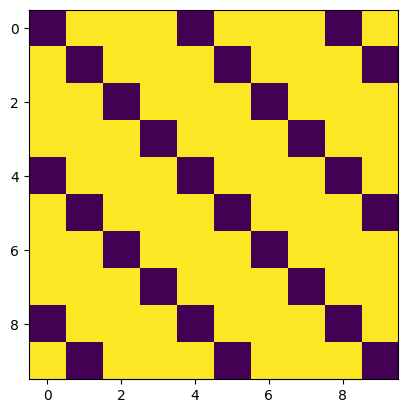

In [26]:
x = torch.ones(size=(10, 10))
for j in range(10):
    for i in [-8, -4, 0, 4, 8]:
        if 0 <= j+i <= 9:
            x[j+i, j] = 0

plt.imshow(x)
plt.show()

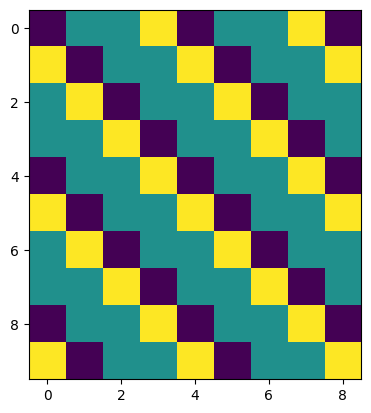

In [27]:
y = corr2d(x, K)
plt.imshow(y)
plt.show()

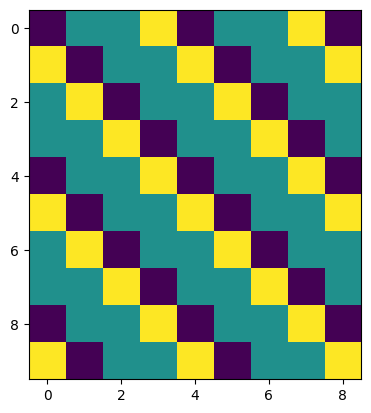

In [28]:
y = corr2d(x.T, K)
plt.imshow(y)
plt.show()

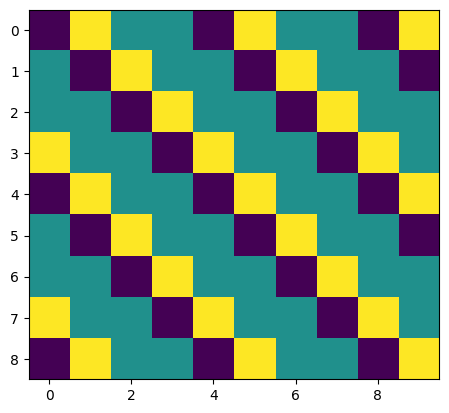

In [29]:
y = corr2d(x, K.T)
plt.imshow(y)
plt.show()

### Ex. 2

In [49]:
print(K)

tensor([[ 1., -1.]])


In [54]:
x = torch.tensor([[0, 0, 1, 100, 0, 0, 0] for i in range(7)])

In [55]:
sec_der = torch.tensor([[1, -2, 1]])

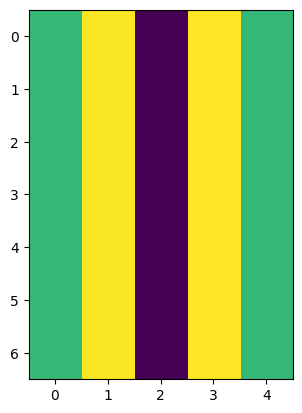

In [56]:
y = corr2d(x, sec_der)
plt.imshow(y)
plt.show()

and in general, the $d-th$ derivates needs a $d+1$-sized tensor.

[Discussions](https://discuss.d2l.ai/t/66)
